<a href="https://colab.research.google.com/github/SalikFillah/Final_Project_AMS/blob/main/Analysis_Sentiment_K_Nearest_Neighbor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Module

In [ ]:
import warnings; warnings.simplefilter('ignore')

!pip install unidecode
!pip install textblob
!pip install sastrawi
!pip install tqdm
!pip install wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=abac7c0f59391d3b856682ef455c2132134a9b24b416363f73b6434831875fd1
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


## Import Module

In [ ]:
import pandas as pd
import re
from unidecode import unidecode
from html import unescape
from tqdm import tqdm
import nltk
from nltk import word_tokenize
nltk.download('punkt')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# modul scikit-learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn import neighbors
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# modul impor file
import urllib.request
import wget

# modul dashboard
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Load Dataset

In [ ]:
df1 = pd.read_csv('https://raw.githubusercontent.com/wiweka24/NLP_Sentiment-Analysis/main/Dataset-Sentimen-Analisis-Bahasa-Indonesia/dataset_komentar_instagram_cyberbullying.csv')
df2 = pd.read_csv('https://raw.githubusercontent.com/wiweka24/NLP_Sentiment-Analysis/main/Dataset-Sentimen-Analisis-Bahasa-Indonesia/dataset_tweet_sentimen_tayangan_tv.csv')
df3 = pd.read_csv('https://raw.githubusercontent.com/wiweka24/NLP_Sentiment-Analysis/main/Dataset-Sentimen-Analisis-Bahasa-Indonesia/dataset_tweet_sentiment_cellular_service_provider.csv')
df4 = pd.read_csv('https://raw.githubusercontent.com/wiweka24/NLP_Sentiment-Analysis/main/Dataset-Sentimen-Analisis-Bahasa-Indonesia/dataset_tweet_sentiment_opini_film.csv')
df5 = pd.read_csv('https://raw.githubusercontent.com/wiweka24/NLP_Sentiment-Analysis/main/Dataset-Sentimen-Analisis-Bahasa-Indonesia/dataset_tweet_sentiment_pilkada_DKI_2017.csv')
print('Successfully Loaded')

Successfully Loaded


In [ ]:
df1 = df1.drop(columns=['Id']).rename(columns={'Instagram Comment Text':'Text'})
df2 = df2.drop(columns=['Id','Acara TV','Jumlah Retweet']).rename(columns={'Text Tweet':'Text'})
df3 = df3.drop(columns=['Id']).rename(columns={'Text Tweet':'Text'})
df4 = df4.drop(columns=['Id']).rename(columns={'Text Tweet':'Text'})
df5 = df5.drop(columns=['Id','Pasangan Calon']).rename(columns={'Text Tweet':'Text'})

df = pd.concat([df1,df2,df3,df4,df5], ignore_index=True)
df.head()

,Sentiment,Text
0,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


## Variabel Hashtag
untuk keperluan feature extraction

In [ ]:
# Menambahkan kolom Hashtag
df['Hashtag'] = df['Text'].str.extract(r'(#\w+)').fillna('')

df.head()
# banyak hashtag yang berbeda
print(len(df.Hashtag.unique()))

354


## Menangani Duplikasi

In [ ]:
df[df.duplicated()==True]

,Sentiment,Text,Hashtag
57,negative,"<USERNAME> ini lagi pemikiran manusia bodoh, ...",
71,negative,<USERNAME> bisa nya cuma ngatain org . Nyindi...,
94,negative,Dasar artis abal abal enggk laku di layar kaca...,
971,positive,Terimakasih ya <PROVIDER_NAME> gratis 4Gnya ay...,
1053,negative,Jaringan internet <PROVIDER_NAME> di sumba tim...,
1255,positive,"pokoknya kalian harus nonton film kartini, asl...",
1280,positive,nah ini. coba nonton filmnya deh. asik parah,
1426,negative,ahoker masih bully #AHY,#AHY
2038,negative,"Setelah KO di beberapa Polling, kini mereka go...",#pilkadadki2017


In [ ]:
# memeriksa duplikasi
print(df.duplicated().sum())

# membuang duplikasi
df.drop_duplicates(inplace=True)
print(df.shape)

9
(2191, 3)


## Preprocessing Data
Setiap model optimal terhadap suatu preprocessing tertentu

### Import Slang
semua sumber dokumen berasal dari github taudata

In [ ]:
url = 'https://raw.githubusercontent.com/taudataid/eLearning/master/data/slang.dic'
response = urllib.request.urlopen(url)
slang_id = eval(response.read())

print("jumlah slang: ", len(slang_id))

jumlah slang:  1629


In [ ]:
# modifikasi sesuka hati jika dirasa masih ada slang yang belum tertangani
slang_tambahan = {
    'hitamputihtrans7': 'hitamputih', 'hitamputiht7': 'hitamputih', 'hitamputih_trans7': 'hitamputih',
    'ahokharusdipenjara': 'ahok', 'ahokdjarotdirosi': 'ahok', 'karanganbungaahok': 'ahok', 'ahokmenang': 'ahok', 'ahokers': 'ahok', 'ahokpenistaagama': 'ahok', 'nyanyianuntukahok': 'ahok', 'ahokdjarot': 'ahok', 'saveahok': 'ahok', 'paradenyanyianuntukahok': 'ahok', 'ahokdicintairakyat': 'ahok', 'gombalinahok': 'ahok', 'ahok4ri': 'ahok', 'terimakasihpakahok': 'ahok', 'besokguaahok': 'ahok', 'ahokselaludihati': 'ahok', 'gueahok': 'ahok', 'ahokfree': 'ahok', 'freeahok': 'ahok', 'demiahok': 'ahok', 'pakahok': 'ahok', 'voteahok': 'ahok', 'tetapahok':'ahok', 'ahoktumbang': 'ahok', 'basukikeokmasukbui': 'ahok',
    'kickandy': 'andy', 'kickand': 'andy', 'kickandyp': 'andy', 'kickandymetrotv': 'andy', 'kickandymetrot': 'andy',
    'matanajwametrotv': 'matanajwa', 'matanajwadebatjakarta': 'matanajwa', 'bataldebatkarena': 'matanajwa',
    'pemilihan kepala daerah': 'pilkada', 'pilkadadki': 'pilkada', 'pilkadadk': 'pilkada', 'pilkadaserentak2017': 'pilkada', 'debatfinalpilkadajkt': 'pilkada', 'debat1pilkadadki': 'pilkada', 'pilkadadkijakarta': 'pilkada', 'pilkadadki2017': 'pilkada', 'pilkadadki201': 'pilkada', 'garagarapilkada': 'pilkada', 'pilkadajakarta': 'pilkada', 'debatpilkadadki': 'pilkada', 'debatfinalpilkadadki': 'pilkada', 'pilka': 'pilkada', 'pilkadaputarankedua': 'pilkada',
    'akucoblosaniessandi': 'aniessandi', 'aniesbaswedan': 'aniessandi', 'anies': 'aniessandi', 'aniessandidki1': 'aniessandi', 'aniessandy': 'aniessandi', 'programaniessandi': 'aniessandi', 'aniessandimenang': 'aniessandi', 'aniesjawarajakarta': 'aniessandi', 'aniessandijawarajakarta': 'aniessandi', 'anissandi': 'aniessandi',
    'geblek': 'goblok', 'moga': 'semoga',
}
slang_id.update(slang_tambahan)

print("jumlah slang : ", len(slang_id))

jumlah slang :  1691



### Import Stopword
semua sumber dokumen berasal dari github taudata

In [ ]:
url = 'https://raw.githubusercontent.com/taudataid/eLearning/master/data/stopwords_id.txt'
response = urllib.request.urlopen(url)
stopword_id = response.read().decode('utf-8').split('\n')

print("jumlah stopword: ", len(stopword_id))

jumlah stopword:  758


In [ ]:
# modifikasi sesuka hati jika dirasa masih ada stopword yang belum tertangani
stopword_tambahan = set(['a', 'ahok', 'ahy', 'anak', 'allah', 'acara', 'ajar', 'aurel', 'artis', 'arti', 'aniessandi',
                         'b', 'bikin', 'bang', 'bangsa', 'bilang', 'bicara', 'biar', 'bilang',
                         'c',
                         'd', 'daerah', 'dki', 'deh', 'dukung',
                         'e', 'eyes',
                         'f', 'face', 'film', 'folded',
                         'g', 'gubernur',
                         'h', 'hand', 'hitam', 'hands',
                         'i', 'ibukota', 'indonesia', 'iya', 'istri',
                         'j', 'jakarta', 'jalan', 'joy', 'jaring',
                         'k', 'khusus', 'kepala', 'keluarga', 'kah', 'kerja', 'kartini',
                         'l', 'lihat', 'laki',
                         'm', 'mata', 'mbak', 'malam', 'muda', 'mas',
                         'n', 'name', 'nonton', 'najwa', 'nya', 'nomor', 'nikah',
                         'o', 'orang', 'of',
                         'p', 'provider', 'putih', 'pak', 'pilih', 'pakai', 'pimpin', 'product', 'program',
                         'q',
                         'r', 'rakyat', 'rumah',
                         's', 'smilling', 'smiling', 'si', 'sih', 'suara', 'suami', 'sinyal', 'sandi', 'salam',
                         't', 'televisi', 'tunggu', 'teman', 'tonton', 'the', 'trans7', 'tuju', 'tears',
                         'u', 'username', 'url',
                         'v',
                         'w', 'with', 'warga',
                         'x',
                         'y',
                         'z',
                         '4g'])
stopword_id = set(stopword_id).union(stopword_tambahan)

print("jumlah stopword: ", len(stopword_id))

jumlah stopword:  871


### Data Cleansing

In [ ]:
def cleaning_text(text):
  # menghapus url
  url_pattern = re.compile(r'(\w+:\/\/\S+)')
  text = url_pattern.sub(' ', text)
  # menghapus hashtag
  hashtag_pattern = re.compile(r'#\w+\b')
  text = hashtag_pattern.sub(' ', text)
  # menghapus nama pengguna instagram (memuat "@")
  username_pattern = re.compile(r'@\w+\b\s*')
  text = username_pattern.sub(' ', text)
  # menghapus angka
  text = re.sub(r'\b\d+\b|[^\w\s]', '', text)
  # mengahpus simbol
  symbol_pattern = re.compile(r'[^\w\s]+')
  text = symbol_pattern.sub(' ', text)
  # menghapus karakter yang tidak diperlukan (tergantung media sosial)
  text = re.sub(r'\n', ' ', text)
  text = re.sub(r'\r', ' ', text)
  text = re.sub(r'&\w+', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  # menangani huruf kapital dan spasi
  text = unidecode(unescape(text.lower().strip()))
  return text

def remove_stopword(text):
  word_tokens = word_tokenize(text)
  filtered_sentence = [w for w in word_tokens if not w in stopword_id]
  return ' '.join(filtered_sentence)

def stemming_and_lemmatization(text):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  return stemmer.stem(text)

def remove_slang(text):
  text = ''.join(slang_id[p] if p in slang_id else p for p in re.split(r'(\W+)', text))
  return text

def preprocess(text):
  # cleaning text and lowercase
  output = cleaning_text(text)
  # remove slang
  output = remove_slang(output)
  # stemming and lemmatization
  output = stemming_and_lemmatization(output)
  # remove stopwords
  output = remove_stopword(output)

  return output

def hashtag_symbol(text):
  hashtag_symbol = re.compile(r'#(\w+)\b')
  text = hashtag_symbol.sub(r'\1', text)
  # menangani huruf kapital dan spasi
  text = unidecode(unescape(text.lower().strip()))
  return text

def cleaning_hashtag(text):
  # menghapus hanya simbol hashtag
  output = hashtag_symbol(text)
  # handle slang
  output = remove_slang(output)

  return output

### clean_text
hasil preprocessing kolom "Text"

In [ ]:
df['clean_text'] = ''
for idx, post in tqdm(df.iterrows()):
  df.at[idx, 'clean_text'] = preprocess(post.Text)

2191it [09:44,  3.75it/s]


### clean_ht
hasil preprocessing kolom "Hashtag"

In [ ]:
df['clean_ht'] = ''
for idx, post in tqdm(df.iterrows()):
  df.at[idx, 'clean_ht'] = cleaning_hashtag(post.Hashtag)

2191it [00:00, 13959.48it/s]


## Ekstraksi Fitur

In [ ]:
# memilih hanya kolom yang sudah bersih
df_knn = df[['Sentiment', 'clean_text', 'clean_ht']]
# memperkaya ekstraksi fitur
df_knn['text_ht'] = df['clean_text'] + '' + df['clean_ht']

df_knn.head()

,Sentiment,clean_text,clean_ht,text_ht
0,negative,tolol hubung gugur hijab syar bayi panas dalem...,,tolol hubung gugur hijab syar bayi panas dalem...
1,negative,goblok tatacowo banget dibela2in balikanhadeww...,,goblok tatacowo banget dibela2in balikanhadeww...
2,negative,kemarin termewek2 skr lengket duhhh labil bang...,,kemarin termewek2 skr lengket duhhh labil bang...
3,negative,inti kesel att gausah kasi kembang psikis tolo...,,inti kesel att gausah kasi kembang psikis tolo...
4,negative,hadewwwww permpuan lgsakit jiwaknp peran utama...,,hadewwwww permpuan lgsakit jiwaknp peran utama...


## Pelatihan Model K-Nearest Neighbor
Pembagian data train dan test

In [ ]:
# 30% data test
test_size = 0.3
# agar ketika di run ulang hasilnya akan sama
seed = 7

X_train, X_test, y_train, y_test = train_test_split(
    df_knn.text_ht,
    df_knn.Sentiment,
    test_size=test_size,
    random_state=seed,
)

print(X_train.shape, X_test.shape)

(1533,) (658,)


## Cross Validasi
Menentukan jumlah k yang optimal menggunakan grid search

In [ ]:
kCV = 5
metric = 'accuracy'
params = {}
params['tfidfvectorizer__min_df'] = [5, 10, 15]
params['tfidfvectorizer__max_df'] = [0.5, 0.75, 0.95]
params['tfidfvectorizer__smooth_idf'] = [True]
params['tfidfvectorizer__sublinear_tf'] = [True]
params['tfidfvectorizer__ngram_range'] = [(1, 1), (1, 2), (1,3)]
params['kneighborsclassifier__n_neighbors'] = [3, 5, 10]
params['kneighborsclassifier__weights'] = ('distance', 'uniform')

pipe = make_pipeline(TfidfVectorizer(), neighbors.KNeighborsClassifier())
gridCV = GridSearchCV(pipe, params, cv=kCV, scoring=metric, verbose=1, n_jobs=-1)
gridCV.fit(X_train, y_train)

# menampilkan hasil parameter optimal
print(gridCV.best_score_)
print(gridCV.best_params_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
0.6627323242000382
{'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__weights': 'distance', 'tfidfvectorizer__max_df': 0.5, 'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__ngram_range': (1, 2), 'tfidfvectorizer__smooth_idf': True, 'tfidfvectorizer__sublinear_tf': True}


## Bentuk VSM
Menggunakan metode TF-IDF

In [ ]:
# atur parameter yang ada sesuai dengan hasil cross validasi
vsm = TfidfVectorizer(lowercase=True, smooth_idf= True, sublinear_tf=True,
                                   ngram_range=(1, 2), max_df=0.5, min_df=5)

x_train = vsm.fit_transform(X_train)
x_test = vsm.transform(X_test)

# pastikan jumlah kolom nya sama
print(x_train.shape, x_test.shape)

(1533, 370) (658, 370)


## Evaluasi Model

In [ ]:
model = neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance')
kNN = model.fit(x_train, y_train)
y_kNN = kNN.predict(x_test)


print('Akurasi = ', accuracy_score(y_test, y_kNN))
print(confusion_matrix(y_test, y_kNN))
# performa model
print(classification_report(y_test, y_kNN))

Akurasi =  0.6276595744680851
[[148 182]
 [ 63 265]]
              precision    recall  f1-score   support

    negative       0.70      0.45      0.55       330
    positive       0.59      0.81      0.68       328

    accuracy                           0.63       658
   macro avg       0.65      0.63      0.62       658
weighted avg       0.65      0.63      0.62       658



## Visualisasi

Text(58.222222222222214, 0.5, 'Truth')

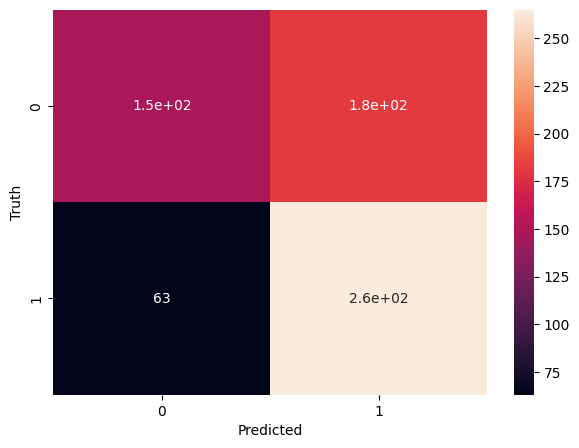

In [ ]:
# visualisasi confusion matrix
cm = confusion_matrix(y_test, y_kNN)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

## Dashboard

### WordCloud

In [ ]:
url = "https://github.com/SalikFillah/Sentiment-Analysis/raw/main/Comfortaa-Bold.ttf"
filename = wget.download(url)

In [ ]:
def wordcloud(result, sentiment, emotion, tweet):
  result_data = result.loc[result[sentiment] == emotion]
  result_data

  allWords  = ' '.join( [str (twts) for twts in result_data[tweet]])
  font = '/content/Comfortaa-Bold.ttf'
  wordCloud = WordCloud(background_color = "white",
                        font_path = font,
                        width = 600,
                        height = 400,
                        max_words = 30,
                        colormap = 'autumn_r').generate(allWords)
  plt.figure(figsize = (10,10))
  plt.imshow(wordCloud, interpolation = 'bilinear')
  plt.axis('off')
  plt.show()

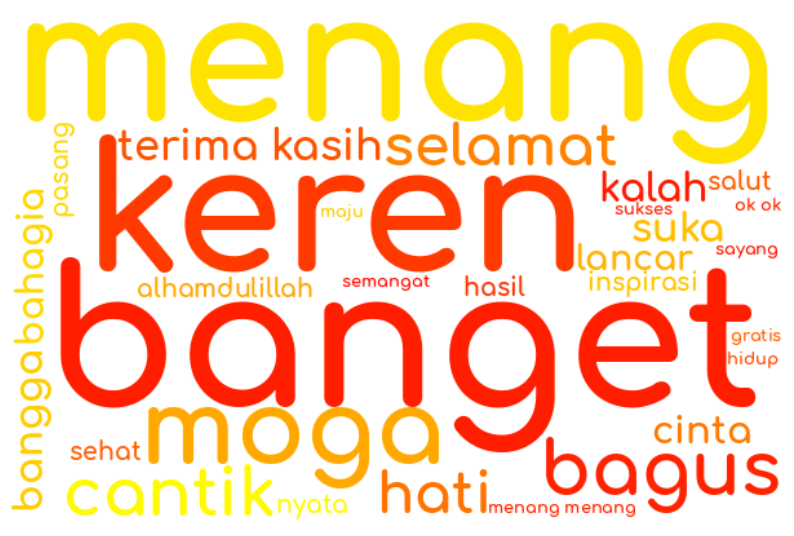

In [ ]:
# WordCloud sentimen positif
wordcloud(df_knn, 'Sentiment', 'positive', 'clean_text')

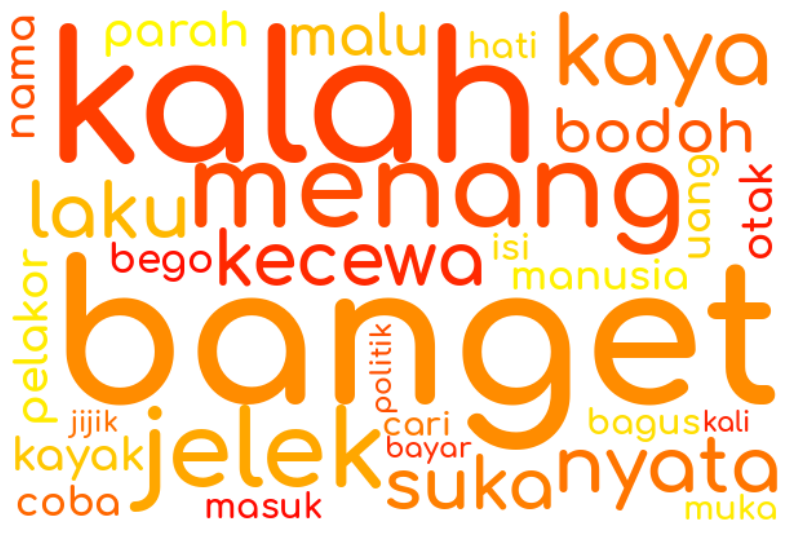

In [ ]:
# WordCloud sentimen negatif
wordcloud(df_knn, 'Sentiment', 'negative', 'clean_text')

## N-Gram

In [ ]:
def tokenization(sentimen, dataframe):
  df_ngram = dataframe[dataframe['Sentiment']==sentimen]
  texts = df_ngram['clean_text']
  tokens = [token for text in texts for token in text.split()]
  return tokens

In [ ]:
ngram_pos = tokenization('positive', df)
print(ngram_pos[:5])
ngram_neg = tokenization('negative', df)
print(ngram_neg[:5])

['sabar', 'yaa', 'insya', 'buka', 'pintu']
['tolol', 'hubung', 'gugur', 'hijab', 'syar']


In [ ]:
bigram_pos = (pd.Series(nltk.ngrams(ngram_pos, 2)).value_counts())[:12]
bigram_neg = (pd.Series(nltk.ngrams(ngram_neg, 2)).value_counts())[:12]

Text(0.5, 0, '# of Occurances')

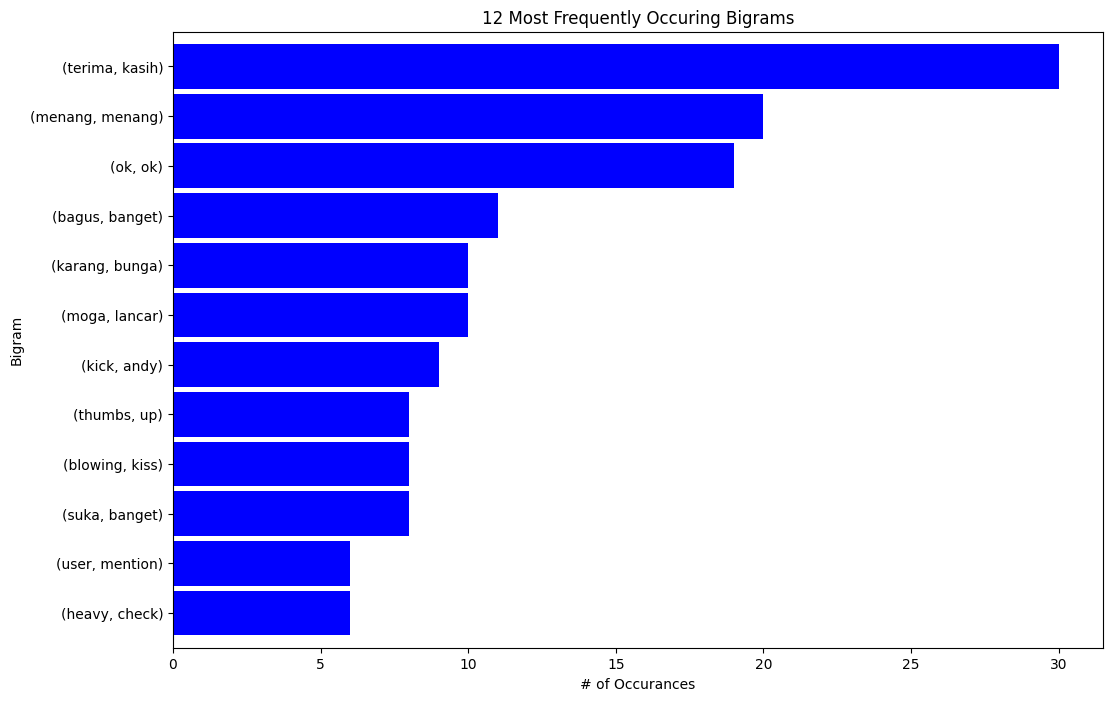

In [ ]:
ax = bigram_pos.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('12 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

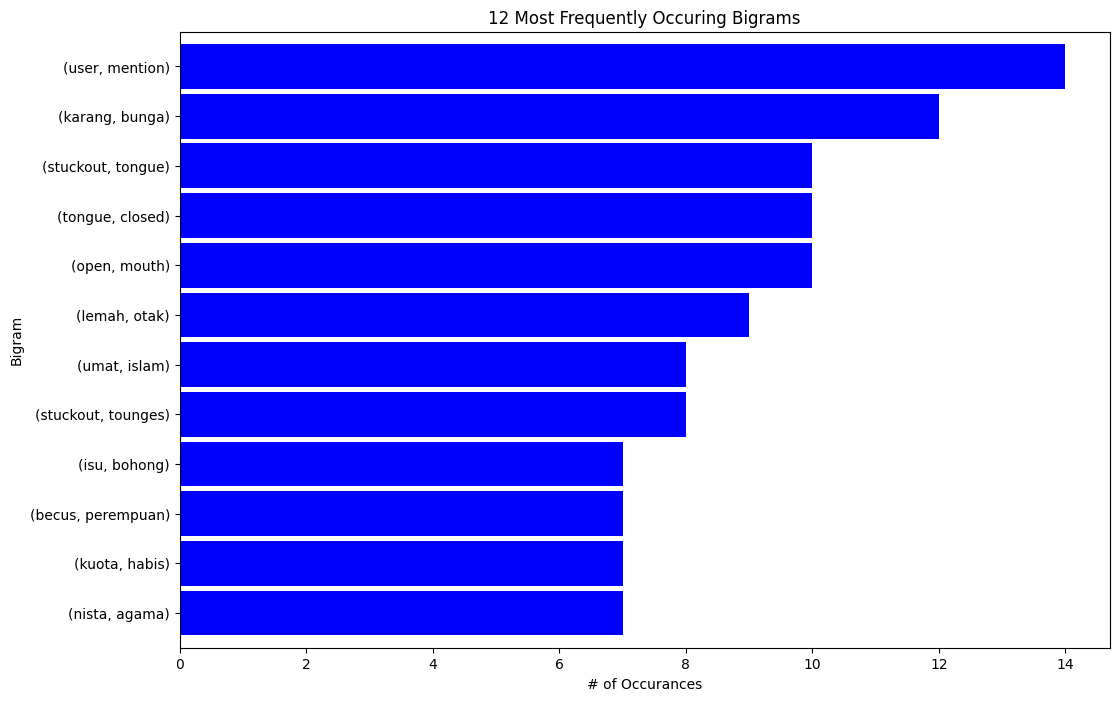

In [ ]:
ax = bigram_neg.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('12 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

### Bar Plot

In [ ]:
def sentiment_sample_data(dataframe):

    sentiment_counts = dataframe.value_counts()
    values_sample = sentiment_counts.keys().tolist()
    counts_sample = sentiment_counts.tolist()

    return values_sample, counts_sample

In [ ]:
values_sample, counts_sample = sentiment_sample_data(df['Sentiment'])

fig = px.bar(
        x=values_sample,
        y=counts_sample,
        labels={"x":"Bar Plot Banyak Sentimen","y": "Jumlah"}
)
fig.update_layout(
    autosize=False,
    margin=dict(t=10, b=10, l=40, r=0, pad=4),
    xaxis=dict(showticklabels=False)
)
fig.show()

In [ ]:
from google.colab import files
df_baru = df[['Sentiment', 'clean_text']]

df_baru.to_csv('data.csv', index=False)
files.download('data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>